<a href="https://colab.research.google.com/github/goflvhxj/ML-practice/blob/main/3_%ED%8F%89%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **03_평가**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'], axis=1,inplace=True)
    return df

# 레이블 인코딩 수행(문자열 변수 수치화)
def format_features(df):
    df['Cabin']=df['Cabin'].str[:1]
    features=['Sex','Cabin','Embarked']
    
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature]=le.transform(df[feature])
    
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    
    return df

---
<br>

## **1. 정확도**
### 이진분류 - 데이터의 구성에 따라 ML 모델의 성능을 왜곡시킬 가능성 존재


In [ ]:
# 성별에 따라 생존자를 예측하는 Classifier

from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    
    def predict(self,X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

titanic_df = pd.read_csv("/content/drive/MyDrive/Jupyter/titanic_train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

myclf = MyDummyClassifier()
myclf.fit(X_train,y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test,mypredictions)))

Dummy Classifier의 정확도는: 0.7877


-> 성별로만 기준을 세워 예측 하였는데 78프로라는 높은 수치가 나옴

특히, 정확도는 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님.

<br>

MNIST 데이터 세트를 불균형한 데이터 세트로 변환하여 정확도 확인
-> 정확도 90%가 나올 것으로 예측됨

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(self,X,y):
    pass

  def predict(self,X): # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    return np.zeros((len(X),1),dtype=bool)

digits = load_digits() # MNIST 데이터 불러오기
# digits = pd.DataFrame(digits.data, columns=digits.feature_names) # 데이터프레임으로 만들어 확인

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7이 아니면 False이고 0으로 변환 -> 불균형한 데이터셋으로 변환
# True.astype(int) = 1, False.astype(int) = 0
y = (digits.target == 7).astype(int)
X_train,X_test,y_train,y_test = train_test_split(digits.data, y, random_state=11)

'''
# astype은 dataframe 형태에서만 가능하므로 ndarray형일땐 pd.Series 통해 바꿔줘야함
a = np.array(['Apple','Pear','Orange','banana'])
print(type(a))
test = (pd.Series(a)=='Apple').astype(int)
print('test:\n',test.tolist())
'''

# 불균형한 레이블 데이터 분포도 확인
print("레이블 테스트 세트 크기 : ", y_test.shape)
print("테스트 세트 레이블 0과 1의 분포도")
print(pd.Series(y_test).value_counts()) # y_test는 np.ndarray 타입이지만 pd.Series통해 value_counts 할 수 있음

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train,y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{0:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 :  (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


digits.target == 7인 경우만 1로 변환하고 나머지는 모두 0으로 설정한 뒤 예측하였을 때 정확도가 90%라는 것은 말이 안됨

따라서 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안됨

---

## **2. 오차 행렬(confusion matrix)**


이진분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred) # 이 순서는 [TN, FP, FN, TP]

array([[405,   0],
       [ 45,   0]])

TN : 예측 거짓 & 실제 거짓<br>
FP : 예측 참 & 실제 거짓(1종오류)<br>
FN : 예측 거짓 & 실제 참(2종오류)<br>
TP : 예측 참 & 실제 참

정확도 = 예측 결과와 실제 값이 동일한 건수/전체 데이터 수 = (TN+TP)/(TN+FP+FN+TP)

----
##**3. 정밀도와 재현율**<br>
- Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표
- 정밀도(양성 예측도) : TP / (FP + TP) -> 예측 값이 참인 것
- 재현율(민감도, TPR(True Positive Rate)) : TP / (FN + TP) -> 실제 값이 참인 것

재현율(recall) : 암이 실제로 걸렸는데 검사 결과 음성일 때 -> 실제로 참인데 예측 거짓일때 -> FN이 치명적인 경우 사용(의료, 보험사기, 금융 사기)<br>
정밀도(precision) : 스팸메일 처리를 했는데 사실은 아닌 경우 업무 메일을 못받음 -> 실제 거짓인데 예측 참일때 -> FP가 치명적인 경우 사용


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):  # 오차행렬, 정확도, 정밀도, 재현율 출력
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}'.format(accuracy, precision, recall))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터 로딩, 데이터 가공, 학습/검증 데이터 분할
titanic_df = pd.read_csv("/content/drive/MyDrive/Jupyter/titanic_train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df) # 데이터 전처리

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 11)
lr_clf = LogisticRegression() # 로지스틱 회귀 기반으로 타이타닉 생존자 예측

lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred) # 오차행렬, 정확도, 정밀도, 재현율 출력

오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
pred_proba = lr_clf.predict_proba(X_test) # 개별 데이터별로 예측 확률 반환, 이진분류에서 칼럼 0은 Negative의 확률, 칼럼 1은 Postivie의 확률 반환
pred = lr_clf.predict(X_test)

print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])


pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46191519 0.53808481]
 [0.878675   0.121325  ]
 [0.87716185 0.12283815]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46191519 0.53808481 1.        ]
 [0.878675   0.121325   0.        ]
 [0.87716185 0.12283815 0.        ]]


In [ ]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
     [2,0,0],
     [0,1.1,1.2]]

# X의 개별 원소들이 threshold(임계값)보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [ ]:
# 타이타닉 데이터에 임계값을 0.5로 지정한 Binarizer 클래스를 적용해 최종 예측값 구하기
from sklearn.preprocessing import Binarizer

# 분류 결정 임곗값을 임의로 지정
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1) # [:,1] : 행은 전체, 열은 1인 모든 데이터 추출
#print("1열 추출 : \n", pred_proba_1[:5])

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) # pred_proba_1에 대해 Binarizer 클래스에 맞춰 임곗값이 0.5이상이면 1, 이하면 0으로 학습
custom_predict = binarizer.transform(pred_proba_1) # 학습한 데이터를 토대로 pred_proba_1 값을 변환(transform)
#print("pred_broba_1 변형 : \n", custom_predict[:5])

#print("\n")
get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869


In [ ]:
# 타이타닉 데이터에 임계값을 0.4로 지정한 Binarizer 클래스를 적용해 최종 예측값 구하기
from sklearn.preprocessing import Binarizer

# 분류 결정 임곗값을 줄였을 때
custom_threshold = 0.4

# predict_proba() 반환값의 두 번째 칼럼, Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1) # [:,1] : 행은 전체, 열은 1인 모든 데이터 추출
#print("1열 추출 : \n", pred_proba_1[:5])

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) # pred_proba_1에 대해 Binarizer 클래스에 맞춰 임곗값이 0.5이상이면 1, 이하면 0으로 학습
custom_predict = binarizer.transform(pred_proba_1) # 학습한 데이터를 토대로 pred_proba_1 값을 변환(transform)
#print("pred_broba_1 변형 : \n", custom_predict[:5])

#print("\n")
get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도:0.8324, 정밀도:0.7183, 재현율:0.8361


<br>임곗값을 낮추면 정밀도가 줄어들고 재현율이 증가한다.<br>
분류 결정 임곗값(threshold)는 Positive 예측값을 결정하는 확률의 기준
<br><br>
재현율 = TP / (실제 참값(고정))<br>
정밀도 = TP / (예측 참값)<br><br>
임곗값을 낮추면 예측 참값이 증가하여 정밀도가 떨어진다.

In [ ]:
# 임곗값을 0.4에서 0.6까지 0.05씩 증가시키며 평가 지표 조사 -> 재현율이 0.4일 때 가장 컸다가 점점 줄어들 것으로 예상
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  # thresholds list 객체 내의 값을 차례로 iteration(반복)하면서 Evaluation 진행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값:', custom_threshold)
    get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)


임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도:0.8324, 정밀도:0.7183, 재현율:0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도:0.8492, 정밀도:0.7656, 재현율:0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도:0.8659, 정밀도:0.8364, 재현율:0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도:0.8771, 정밀도:0.8824, 재현율:0.7377


<br>

임곗값이 커질수록 양성 예측도인 정밀도는 예측 참값이 작아지므로 분모가 작아져 정밀도 값은 증가하고 재현율 값은 감소하는 양상을 확인할 수 있다.

In [ ]:
# 정밀도 및 재현율을 precision_recall_curve() 사용하여 확인

from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임곗값 배열 로우가 143건이므로 샘플로 10건만 추출, 임곗값을 15 Step으로 추출
thr_index = np.arange(0,thresholds.shape[0],15)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임곗값에 따른 정밀도와 재현율 값
print('샘플 임곗값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임곗값별 재현율:', np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임곗값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값: [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임곗값별 정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임곗값별 재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


<br>

### 정밀도와 재현율 곡선 시각화

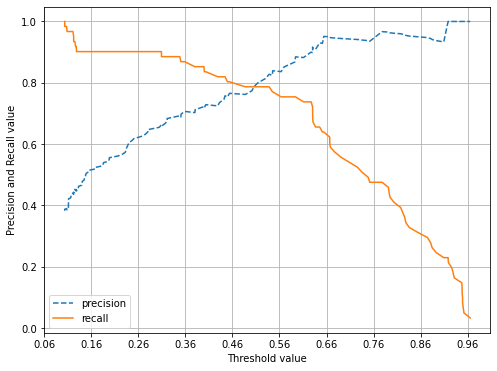

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)

  # x축을 thresholds, y축 : 정밀도, 재현율 값으로 각각 Plot수행, 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0] # 행 끝번호
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim() # x축 범위 반환
  plt.xticks(np.round(np.arange(start,end,0.1),2)) # 축 간격을 구분하기 위한 눈금표시
  
  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1]) # 로지스틱 회귀모형 사용한 것

----
<br>

## 4. F1 스코어

F1 스코어 : 정밀도와 재현율을 결합한 지표<br>
정밀도와 재현율이 **어느 한쪽으로 치우치지 않는 수치**를 나타낼 때 상대적으로 **높은 값**을 가짐

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print('F1 스코어:{0:.4f}'.format(f1))

F1 스코어:0.7805


In [ ]:
# 위에서 만든 get_clf_eval 함수에 f1 스코어 계산하는 함수 추가하여 정밀도, 재현율, f1스코어 비교
def get_clf_eval(y_test,pred):
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)  # f1스코어 계산 추가
  print('오차행렬')
  print(confusion)

  print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f}'.format(accuracy,precision,recall,f1))

thresholds = [0.4,0.45,0.5,0.55,0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차행렬
[[98 20]
 [10 51]]
정확도:0.8324, 정밀도:0.7183, 재현율:0.8361, F1:0.7727
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도:0.8492, 정밀도:0.7656, 재현율:0.8033, F1:0.7840
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869, F1:0.7805
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도:0.8659, 정밀도:0.8364, 재현율:0.7541, F1:0.7931
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도:0.8771, 정밀도:0.8824, 재현율:0.7377, F1:0.8036


임곗값이 0.6일 때 가장 좋은 F1값을 나타냄

-----
<br>

## 5. ROC곡선과 AUC

- 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표
- ROC : FPR(False Postive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지를 나타내는 곡선, X축 : FPR, Y축 : TPR
- TPR(True Positive Rate, 재현율) : TP / (FN + TP)
- TNR(True Negative Rate, 특이성) : TN / (FP + TN)
- FPR(False Positive Rate) : 1 - 특이성(TNR)

In [ ]:
# titanic 생존자 예측 모델의 FPR, TPR, 임곗값 구하기

from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0],5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index],2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값: [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


임곗값이 1에 가까운 값에서 점점 작아질 때 FPR은 점점 커지는 모습을 볼 수 있다. 이때, TPR은 가파르게 상승하는 모습을 보인다.

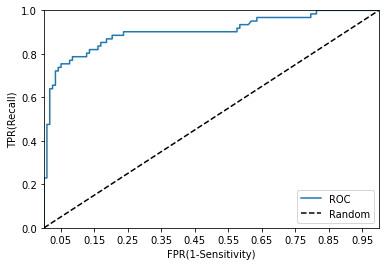

In [ ]:
# ROC 곡선으로 시각화(X:FPR, Y:TPR)
def roc_curve_plot(y_test, pred_proba_c1):
  # 임곗값에 따른 FPR, TPR 값을 반환
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
  
  # ROC 곡선을 그래프 곡선으로 그림
  plt.plot(fprs, tprs, label='ROC')

  # 가운데 대각선 직선을 그림
  plt.plot([0,1],[0,1], 'k--', label='Random')

  # FPR X축의 Scale을 0.1단위로 변경, X,Y축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))
  plt.xlim(0,1); plt.ylim(0,1)
  plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])


- ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는데 이용
- 분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC(Area Under Curve) 값으로 결정
- AUC 값은 **ROC 곡선 밑의 면적을 구한 것**으로서 일반적으로 1에 가까울수록 좋은 수치
- AUC 값이 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻느냐가 관건
- 보통의 분류는 0.5이상의 AUC 값 가짐


In [ ]:
# AUC(ROC 곡선 밑의 면적, 1에 가까울수록 좋음) 값 구하기
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test,pred_proba)
print('ROC AUC 값:{0:.4f}'.format(roc_score))

ROC AUC 값:0.9024


타이타닉 생존자 예측 로지스틱 회귀 모델의 ROC AUC 값은 약 0.9024로 측정됨

In [ ]:
# get_clf_eval함수에 ROC AUC값을 구하는 로직 추가
def get_clf_eval(y_test,pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test,pred)
 
  # ROC-AUC 구하는 로직 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  
  print('오차행렬')
  print(confusion)
  print("정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f}, AUC:{4:.4f}".format(accuracy,precision,recall,f1,roc_auc))

# pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1] # predict_proba : 각 샘플에 대해 어느 클래스에 속할 확률을 0에서 1사이의 값으로 반환해줌
get_clf_eval(y_test, pred=pred, pred_proba=pred_proba)

오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492, 정밀도:0.7742, 재현율:0.7869, F1:0.7805, AUC:0.9024


----
<br>

## 6. 피마 인디언 당뇨병 예측

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('/content/drive/MyDrive/Jupyter/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [ ]:
# NULL개수와 feature의 type 파악
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값, 칼럼 위치 -1을 이용하여 추출

X = diabetes_data.iloc[:,:-1] # 레이블을 제외한 피처 데이터들
y = diabetes_data.iloc[:,-1]  # 레이블 값(당뇨병 양성,음성 라벨링)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)


오차행렬
[[88 12]
 [23 31]]
정확도:0.7727, 정밀도:0.7209, 재현율:0.5741, F1:0.6392, AUC:0.7919


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


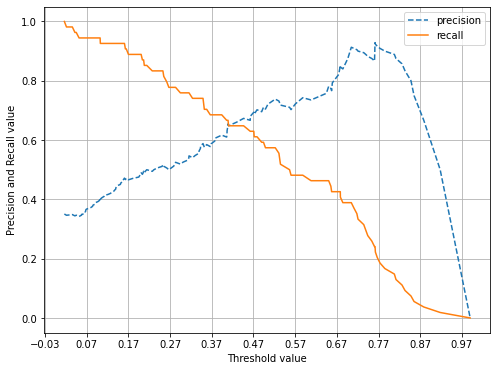

In [ ]:
# 정밀도 재현율 곡선을 통해 임곗값별 정밀도와 재현율 값의 변화 확인
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

임곗값이 0.42 정도일 때 균형을 이루지만 두 개의 지표 모두 0.7이 안되는 값으로 낮은 값을 보인다. 따라서 임곗값을 임의로 조작하기 전에 원본 데이터 값을 점검

In [ ]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min값이 0인 피처들이 굉장히 많이 보임. 하지만 Glucose 같은 피처는 포도당 수치인데 min값이 0인 것은 말이 되지 않는다.<br>
히스토그램을 통해 0값이 어느 정도 존재하는지 확인

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

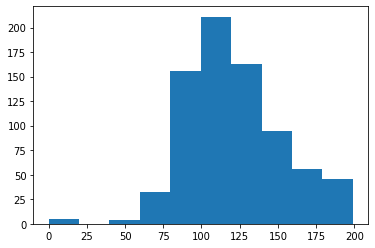

In [ ]:
plt.hist(diabetes_data['Glucose'],bins=10)

'Glucose' 피처에서 0값이 일정 수준 존재하는 것을 알 수 있음

min값이 0인 피처에 대해 0값의 건수 및 전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지 확인

In [ ]:
# 0값을 검사할 피처 명 리스트
zero_features = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수 추출, 퍼센트 계산
for feature in zero_features:
  zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
  print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f}%'.format(feature,zero_count, zero_count/total_count*100))

Glucose 0 건수는 5, 퍼센트는 0.65%
BloodPressure 0 건수는 35, 퍼센트는 4.56%
SkinThickness 0 건수는 227, 퍼센트는 29.56%
Insulin 0 건수는 374, 퍼센트는 48.70%
BMI 0 건수는 11, 퍼센트는 1.43%


SkinThickness와 Insulin의 0의 값이 굉장히 많음. 이때 데이터의 건수가 작으므로 삭제할 경우 학습을 효과적으로 수행할 수 없어 위 피처의 0값을 평균값으로 대체

In [ ]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
print(mean_zero_features)
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0,mean_zero_features)

Glucose          121.681605
BloodPressure     72.254807
SkinThickness     26.606479
Insulin          118.660163
BMI               32.450805
dtype: float64


0값을 평균값으로 대체한 데이터 세트에 피처 스케일링을 적용해 변환<br>
로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋음

In [ ]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

# StandardScaler 클래스 이용하여 피처 데이터 세트에 표준화 작업
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, F1:0.6804, AUC:0.8433


데이터 변환과 스케일링을 통해 성능 수치가 일정 수준 개선되었지만 재현율은 아직도 개선이 필요해 보임.<br>
임곗값을 변화시키며 재현율 값의 수치를 개선시켜보겠음

In [ ]:
thresholds = [0.3,0.33,0.36,0.39,0.42,0.45,0.48,0.50]
pred_proba = lr_clf.predict_proba(X_test)

#get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)
# 왜 에러뜨지..

임곗값: 0.3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:546: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_score = check_array(y_score, ensure_2d=False)


ValueError: ignored

In [ ]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval(y_test,pred_th_048, pred_proba[:,1])

오차행렬
[[88 12]
 [19 35]]
정확도:0.7987, 정밀도:0.7447, 재현율:0.6481, F1:0.6931, AUC:0.8433
